In [1]:

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward, TrajectoryIMFReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

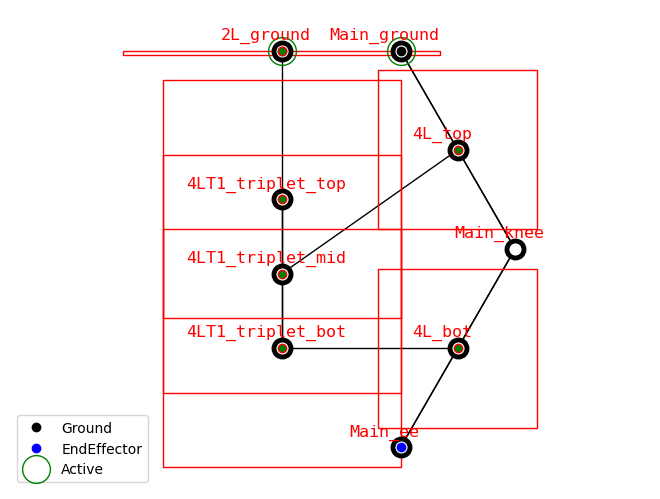

In [2]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[2]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

In [3]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass()
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ),
    "IMF": ImfCompute(ImfProjections.Z),
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)


# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [4]:
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1, 0.4, 0, 50))

acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error')
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [central_vertical])
reward_manager = RewardManager(crag=crag)
# reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_vertical, 0)
reward_manager.add_reward(acceleration_capability, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

acceleration_capability_weight = 1/(-best_reward.item())

Best reward in : [43.87634343]


In [5]:
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1, 0.4, 0, 50))

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error')
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [central_vertical])
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(central_vertical, 0)
reward_manager.add_reward(heavy_lifting, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

heavy_lifting_weight = 1/(-best_reward.item())

Best reward in : [30.42935599]


In [6]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.25, -0.9], step_height=0.2, step_width=0.5, n_points=50))

acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error')
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step])
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_reward(acceleration_capability, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

acceleration_capability_weight_step = 1/(-best_reward.item())

Best reward in : [29.79770368]


In [7]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.25, -0.9], step_height=0.2, step_width=0.5, n_points=50))

trajectory_imf = TrajectoryIMFReward(imf_key='IMF', trajectory_key="traj_6d", error_key="error")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error')
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step])
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_reward(trajectory_imf, 0, 1)

population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

trajectory_imf_weight_step = 1/(-best_reward.item())

Best reward in : [0.59590113]


In [8]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.25, -0.9], step_height=0.2, step_width=0.5, n_points=50))
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1, 0.4, 0, 50))

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error')

soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step, central_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_vertical, 1)
reward_manager.add_reward(acceleration_capability, 0, acceleration_capability_weight_step)
reward_manager.add_reward(trajectory_imf, 0, trajectory_imf_weight_step)
reward_manager.add_reward(acceleration_capability, 1, acceleration_capability_weight)
reward_manager.add_reward(heavy_lifting, 1, heavy_lifting_weight)

In [9]:
population_size = 32
n_generations = 200

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "st_acc_imf_v_acc_hl_generator_2", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed":1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -5.751750E-01 | -1.097089E+00
     2 |       64 |  0.15310 |       3 |  0.4981 |  2.00000 |  2.01611 | -8.550946E-01 | -1.469774E+00
     3 |       96 |  0.21957 |       3 |  0.5413 |  1.99210 |  2.02789 | -1.086273E+00 | -1.846454E+00
     4 |      128 |  0.21930 |       3 |  0.5411 |  1.98254 |  2.04162 | -1.334788E+00 | -2.165238E+00
     5 |      160 | -2.8E-02 |       3 |  0.3826 |  1.97111 |  2.05133 | -1.516317E+00 | -2.165238E+00
     6 |      192 | -1.8E-02 |       3 |  0.3886 |  1.96095 |  2.06584 | -1.631571E+00 | -2.165238E+00
     7 |      224 | -1.9E-02 |       3 |  0.3880 |  1.94858 |  2.07101 | -1.823579E+00 | -2.280503E+00
     8 |      256 | -1.7E-02 |       3 |  0.3893 |  1.94055 |  2.08870 | -1.996029E+00 | -2.543128E+00
     9 |      288 |  0.03130 |       3 |  0.4197 |  1.92751 |  2.09408 | 

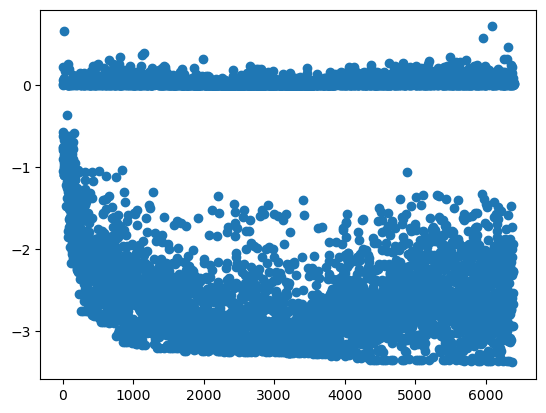

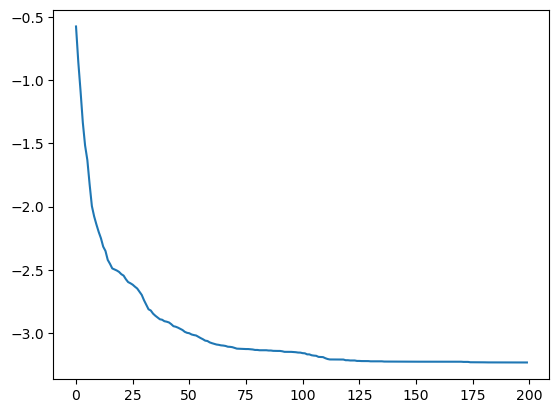

In [10]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

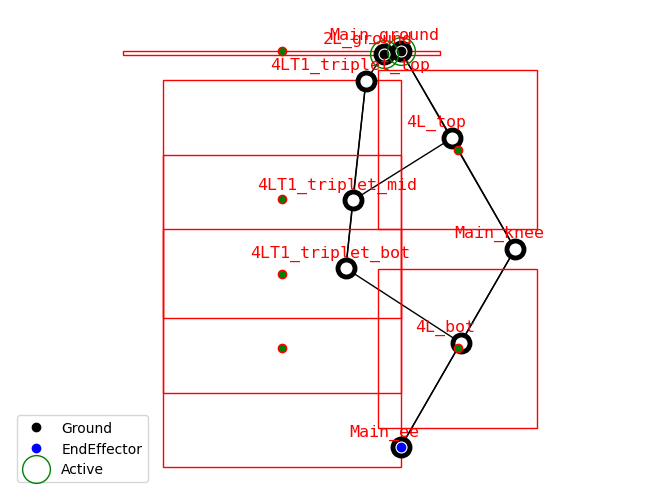

In [11]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
visualize_constrains(problem.graph, constrain_dict)

In [12]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.        , 24.2604246 ,  0.42085785],
       [ 1.        , 60.07733843, 14.85752255]])

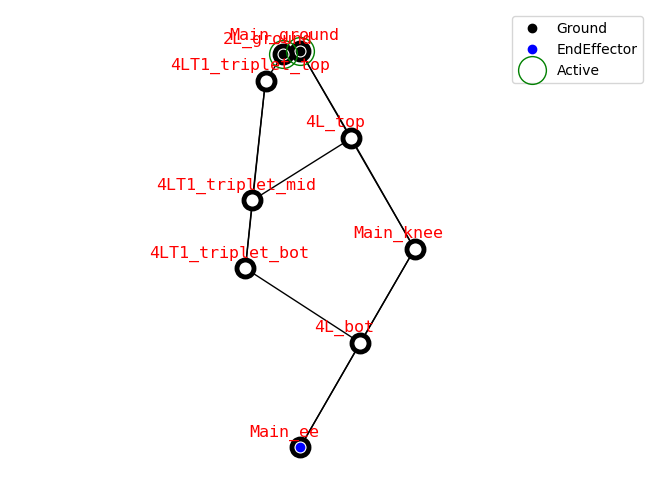

In [13]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

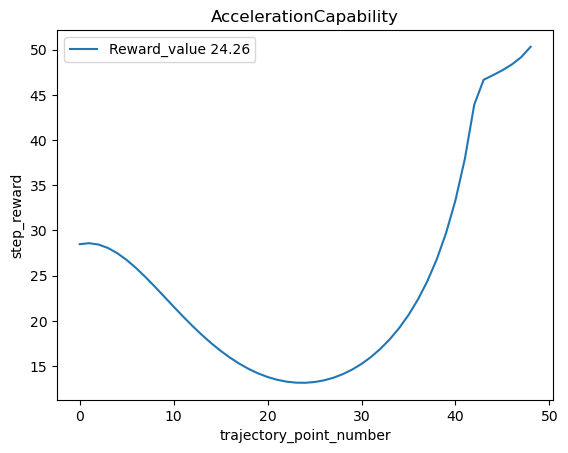

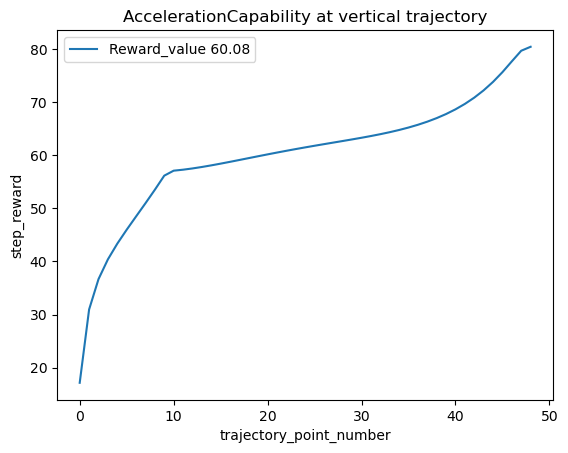

14.857522553162315


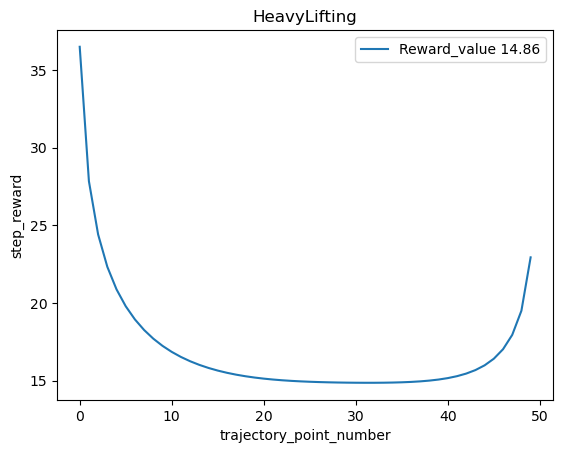

In [14]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[1]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, central_vertical)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability at vertical trajectory')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()


fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, central_vertical)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
print(reward)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()